# 1. Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib tqdm

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tqdm import tqdm

# 2. Keypoints using MediaPipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [22]:
cap.release()
cv2.destroyAllWindows()

In [7]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,) as holistic:
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
        
        #print(results)
        
        draw_styled_landmarks(image, results)
        
        cv2.imshow("MediaPipe Landmarks Feed", image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# 3. Extract Keypoint Values 

In [9]:
len(results.face_landmarks.landmark)

468

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]), lh, rh

In [11]:
temp_result = extract_keypoints(results)
len(temp_result)

3

# 4. Setup Folders for collection & Collect Keypoints Values for Training/Validation and Testing

In [7]:
!pwd

/home/aayush/Thesis/Thesis2022/my_project


In [8]:
import json

BASE_PATH = '../WLASL/data/WLASL2000/'
DATA_PATH = os.path.join('WLASL2000_KP')

with open('../WLASL/WLASL_v0.3.json', 'r') as f:
        data1 = json.load(f)

In [24]:


for gloss in tqdm(data1):
    
    for instance in gloss['instances']:
        
        vid_path = os.path.join(BASE_PATH, instance['video_id']+'.mp4')
        if not os.path.exists(vid_path):
            print(vid_path)
            exit()
        
        kp_path = os.path.join(DATA_PATH, gloss['gloss'], instance['video_id'])
                
        if not os.path.exists(kp_path):
            os.makedirs(kp_path)
            
        print("Working on ", kp_path)
        
        cap = cv2.VideoCapture(vid_path)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
        seq_length = int(cv2.VideoCapture(vid_path).get(cv2.CAP_PROP_FRAME_COUNT))
        
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,) as holistic:
            
            for frame_num in range(seq_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Export keypoints
                keypoints, lh, rh = extract_keypoints(results)
                
                npy_path = os.path.join(kp_path, str(frame_num))
                np.save(npy_path, keypoints)


                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()
        #break
    #break

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

Working on  WLASL2000_KP/book/69241
Working on  WLASL2000_KP/book/65225
Working on  WLASL2000_KP/book/68011
Working on  WLASL2000_KP/book/68208
Working on  WLASL2000_KP/book/68012
Working on  WLASL2000_KP/book/70212
Working on  WLASL2000_KP/book/70266
Working on  WLASL2000_KP/book/07085
Working on  WLASL2000_KP/book/07086
Working on  WLASL2000_KP/book/07087
Working on  WLASL2000_KP/book/07069
Working on  WLASL2000_KP/book/07088
Working on  WLASL2000_KP/book/07089
Working on  WLASL2000_KP/book/07090
Working on  WLASL2000_KP/book/07091
Working on  WLASL2000_KP/book/07092
Working on  WLASL2000_KP/book/07093
Working on  WLASL2000_KP/book/07068
Working on  WLASL2000_KP/book/07094
Working on  WLASL2000_KP/book/07095
Working on  WLASL2000_KP/book/07096
Working on  WLASL2000_KP/book/07097
Working on  WLASL2000_KP/book/07070
Working on  WLASL2000_KP/book/07098
Working on  WLASL2000_KP/book/07099
Working on  WLASL2000_KP/book/07071
Working on  WLASL2000_KP/book/07072
Working on  WLASL2000_KP/boo

  0%|                                      | 1/2000 [02:35<86:28:18, 155.73s/it]

Working on  WLASL2000_KP/drink/69302
Working on  WLASL2000_KP/drink/65539
Working on  WLASL2000_KP/drink/70173
Working on  WLASL2000_KP/drink/68538
Working on  WLASL2000_KP/drink/68042
Working on  WLASL2000_KP/drink/68660
Working on  WLASL2000_KP/drink/68041
Working on  WLASL2000_KP/drink/17725
Working on  WLASL2000_KP/drink/17726
Working on  WLASL2000_KP/drink/17727
Working on  WLASL2000_KP/drink/17728
Working on  WLASL2000_KP/drink/17710
Working on  WLASL2000_KP/drink/17729
Working on  WLASL2000_KP/drink/17730
Working on  WLASL2000_KP/drink/17731
Working on  WLASL2000_KP/drink/17732
Working on  WLASL2000_KP/drink/17733
Working on  WLASL2000_KP/drink/65540
Working on  WLASL2000_KP/drink/17734
Working on  WLASL2000_KP/drink/17711
Working on  WLASL2000_KP/drink/17712
Working on  WLASL2000_KP/drink/17713
Working on  WLASL2000_KP/drink/17714
Working on  WLASL2000_KP/drink/17715
Working on  WLASL2000_KP/drink/17716
Working on  WLASL2000_KP/drink/17717
Working on  WLASL2000_KP/drink/17718
W

  0%|                                      | 2/2000 [04:27<72:02:50, 129.82s/it]

Working on  WLASL2000_KP/computer/12306
Working on  WLASL2000_KP/computer/68028
Working on  WLASL2000_KP/computer/69054
Working on  WLASL2000_KP/computer/12328
Working on  WLASL2000_KP/computer/12329
Working on  WLASL2000_KP/computer/12330
Working on  WLASL2000_KP/computer/12312
Working on  WLASL2000_KP/computer/12331
Working on  WLASL2000_KP/computer/12332
Working on  WLASL2000_KP/computer/12333
Working on  WLASL2000_KP/computer/12335
Working on  WLASL2000_KP/computer/12336
Working on  WLASL2000_KP/computer/12311
Working on  WLASL2000_KP/computer/12337
Working on  WLASL2000_KP/computer/12338
Working on  WLASL2000_KP/computer/12313
Working on  WLASL2000_KP/computer/12314
Working on  WLASL2000_KP/computer/12315
Working on  WLASL2000_KP/computer/12316
Working on  WLASL2000_KP/computer/12317
Working on  WLASL2000_KP/computer/12318
Working on  WLASL2000_KP/computer/12319
Working on  WLASL2000_KP/computer/12320
Working on  WLASL2000_KP/computer/67519
Working on  WLASL2000_KP/computer/12321


  0%|                                      | 3/2000 [06:13<66:07:42, 119.21s/it]

Working on  WLASL2000_KP/before/05724
Working on  WLASL2000_KP/before/70348
Working on  WLASL2000_KP/before/68007
Working on  WLASL2000_KP/before/05744
Working on  WLASL2000_KP/before/05746
Working on  WLASL2000_KP/before/05728
Working on  WLASL2000_KP/before/05747
Working on  WLASL2000_KP/before/05748
Working on  WLASL2000_KP/before/05749
Working on  WLASL2000_KP/before/05750


  0%|                                      | 3/2000 [06:45<74:55:09, 135.06s/it]


KeyboardInterrupt: 

### Previous one (basic)

DATA_PATH = os.path.join('MP_DATA')

actions = np.array(['hello', 'thank you', 'i love you']) ###for MP_DATA
#actions = np.array(['hello!', 'thank you!', 'what\'s up?', 'i\'m good.'])   ###for MP_DATA_1

no_sequences = 60
sequence_length = 30
start_folder = 30

for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,) as holistic:
    
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints, lh, rh = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

        
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create labels and features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

2022-04-19 10:06:01.537213: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aayush/Thesis/Thesis2022/my_project/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-19 10:06:01.537283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
## for the new data WLASL2000

glosses = []
for gloss in data1:
    glosses.append(gloss['gloss'])

label_map = {label:num for num, label in enumerate(glosses)}
label_map

{'book': 0,
 'drink': 1,
 'computer': 2,
 'before': 3,
 'chair': 4,
 'go': 5,
 'clothes': 6,
 'who': 7,
 'candy': 8,
 'cousin': 9,
 'deaf': 10,
 'fine': 11,
 'help': 12,
 'no': 13,
 'thin': 14,
 'walk': 15,
 'year': 16,
 'yes': 17,
 'all': 18,
 'black': 19,
 'cool': 20,
 'finish': 21,
 'hot': 22,
 'like': 23,
 'many': 24,
 'mother': 25,
 'now': 26,
 'orange': 27,
 'table': 28,
 'thanksgiving': 29,
 'what': 30,
 'woman': 31,
 'bed': 32,
 'blue': 33,
 'bowling': 34,
 'can': 35,
 'dog': 36,
 'family': 37,
 'fish': 38,
 'graduate': 39,
 'hat': 40,
 'hearing': 41,
 'kiss': 42,
 'language': 43,
 'later': 44,
 'man': 45,
 'shirt': 46,
 'study': 47,
 'tall': 48,
 'white': 49,
 'wrong': 50,
 'accident': 51,
 'apple': 52,
 'bird': 53,
 'change': 54,
 'color': 55,
 'corn': 56,
 'cow': 57,
 'dance': 58,
 'dark': 59,
 'doctor': 60,
 'eat': 61,
 'enjoy': 62,
 'forget': 63,
 'give': 64,
 'last': 65,
 'meet': 66,
 'pink': 67,
 'pizza': 68,
 'play': 69,
 'school': 70,
 'secretary': 71,
 'short': 72,
 '

In [11]:
label_map['suggest']

999

In [82]:
'''label_map = {label:num for num, label in enumerate(actions)}
label_map'''

{'hello': 0, 'thank you': 1, 'i love you': 2}

In [26]:
count = 0
sequences, labels = [], []
for gloss in data1:
    
    for inst in gloss['instances']:
        
        window = []
        print(gloss['gloss'], inst['video_id'], len(os.listdir(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id']))))
        
        for frame_num in range(len(os.listdir(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id'])))):
            res = np.load(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id'], "{}.npy".format(frame_num))
                          ,allow_pickle=True)
            #print(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id'], "{}.npy".format(frame_num)))
            #print(frame_num)
            window.append(res)
            #break
        sequences.append(window)
        labels.append(label_map[gloss['gloss']])
        #break
    count += 1
    if count==3:
        break
    #break

book 69241 64
book 65225 64
book 68011 47
book 68208 124
book 68012 96
book 70212 100
book 70266 121
book 07085 93
book 07086 100
book 07087 80
book 07069 31
book 07088 87
book 07089 77
book 07090 95
book 07091 75
book 07092 78
book 07093 85
book 07068 58
book 07094 88
book 07095 86
book 07096 83
book 07097 63
book 07070 73
book 07098 124
book 07099 74
book 07071 18
book 07072 18
book 07073 28
book 67424 33
book 07074 33
book 07075 69
book 07076 90
book 07077 99
book 07078 79
book 07079 93
book 07080 104
book 07081 75
book 07082 82
book 07083 98
book 07084 80
drink 69302 66
drink 65539 46
drink 70173 122
drink 68538 133
drink 68042 76
drink 68660 54
drink 68041 89
drink 17725 59
drink 17726 65
drink 17727 82
drink 17728 58
drink 17710 60
drink 17729 61
drink 17730 69
drink 17731 61
drink 17732 55
drink 17733 79
drink 65540 48
drink 17734 76
drink 17711 69
drink 17712 45
drink 17713 78
drink 17714 55
drink 17715 55
drink 17716 57
drink 17717 46
drink 17718 58
drink 17709 105
drink 67594

In [27]:
sequences[3]

[array([ 0.52904528,  0.37300807, -0.91032112, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52886939,  0.37324086, -0.84059507, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52914578,  0.37436995, -0.76368582, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53088349,  0.37500525, -0.79421711, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53105837,  0.375927  , -0.79739404, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53125203,  0.37644824, -0.79360527, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53178215,  0.37675008, -0.78929067, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53179061,  0.37682992, -0.78645444, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53247905,  0.37683782, -0.78156936, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53249949,  0.37690255, -0.79509753, ...,  0.        ,
         0.        ,  0.  

In [12]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2022-04-15 14:01:42.874364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 14:01:42.876580: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 14:01:42.886370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-15 14:01:44.178953: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-15 14:01:44.178982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aayush-Ubuntu): /proc/driver/nvidia/version does not exist


SystemError: GPU device not found

In [28]:
len(sequences)

#temp = tf.ragged.constant(sequences, )

105

In [29]:
X = np.array(sequences, dtype=object)
X.shape

(105,)

In [30]:
Y = to_categorical(labels).astype(int)
Y.shape

(105, 3)

In [31]:
X

array([list([array([ 0.50902992,  0.30827689, -0.6911478 , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50882411,  0.30800119, -0.69519126, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50748807,  0.30555418, -0.72100961, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50814575,  0.30608875, -0.80426836, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50855339,  0.30594823, -0.75825244, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50767273,  0.30561095, -0.64850903, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.50593495,  0.30436674, -0.5875361 , ...,  0.41696009,
        0.87321997,  0.13217968]), array([ 0.50575882,  0.30335671, -0.59773773, ...,  0.42803732,
        0.88305992, -0.03979858]), array([ 0.50605792,  0.30386543, -0.64492559, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.5064072 ,  0.30391949, -0.70963627, ...,  0.39678308,
        0.78361171, -0.1603094 ]

In [21]:
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp = train_test_split(X, Y, test_size=0.05)

In [18]:
X_train_temp.shape

NameError: name 'X_train_temp' is not defined

In [43]:
X_test_temp.shape

(4,)

In [25]:
X_train_temp

array([list([array([ 0.53482109,  0.30566812, -0.61471021, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.5375309 ,  0.307531  , -0.58981359, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.53797609,  0.30881348, -0.65683001, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.53888315,  0.30769953, -0.64618266, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.54049087,  0.30801943, -0.64613652, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.54272968,  0.30758837, -0.58644688, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.54277414,  0.30772185, -0.632559  , ...,  0.        ,
        0.        ,  0.        ]), array([ 0.54102582,  0.30896044, -0.63232547, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.53860241,  0.3108331 , -0.59843594, ...,  0.        ,
        0.        ,  0.        ]), array([ 0.53950351,  0.30931848, -0.58980101, ...,  0.        ,
        0.        ,  0.        ]

In [88]:
np.array(X[0])

array([[ 0.50902992,  0.30827689, -0.6911478 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50882411,  0.30800119, -0.69519126, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50748807,  0.30555418, -0.72100961, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5057869 ,  0.31751639, -0.73385543, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50590616,  0.31755728, -0.72630435, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5060308 ,  0.31756362, -0.72327626, ...,  0.        ,
         0.        ,  0.        ]])

In [32]:
X_train = []
X_test = []
Y_train = []
Y_test = []

count = 0
i = 0
traincount = 0
testcount = 0
for gloss in data1:
    
    
    for inst in gloss['instances']:
        
        print(gloss['gloss'], inst['video_id'], inst['split'])
        if inst['split'] == 'train' or inst['split'] == 'val':
            #traincount += len(os.listdir(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id'])))
            print("train",i)
            X_train.append(np.array(X[i]))
            Y_train.append(np.array(Y[i]))
            
        elif inst['split'] == 'test':
            #testcount += len(os.listdir(os.path.join(DATA_PATH, gloss['gloss'], inst['video_id'])))
            print("test",i)
            X_test.append(np.array(X[i]))
            Y_test.append(np.array(Y[i]))
            
        i += 1        
        
    count += 1
    if count == 3:
        break

X_train = np.array(X_train, dtype = object)
Y_train = np.array(Y_train)

X_test = np.array(X_test, dtype = object)
Y_test = np.array(Y_test)

book 69241 train
train 0
book 65225 train
train 1
book 68011 train
train 2
book 68208 train
train 3
book 68012 train
train 4
book 70212 val
train 5
book 70266 train
train 6
book 07085 train
train 7
book 07086 train
train 8
book 07087 train
train 9
book 07069 train
train 10
book 07088 train
train 11
book 07089 train
train 12
book 07090 train
train 13
book 07091 train
train 14
book 07092 test
test 15
book 07093 test
test 16
book 07068 train
train 17
book 07094 val
train 18
book 07095 test
test 19
book 07096 val
train 20
book 07097 train
train 21
book 07070 train
train 22
book 07098 val
train 23
book 07099 val
train 24
book 07071 train
train 25
book 07072 test
test 26
book 07073 train
train 27
book 67424 train
train 28
book 07074 train
train 29
book 07075 train
train 30
book 07076 train
train 31
book 07077 train
train 32
book 07078 train
train 33
book 07079 train
train 34
book 07080 train
train 35
book 07081 train
train 36
book 07082 train
train 37
book 07083 val
train 38
book 07084 train

In [33]:
#X_train.append(X[2])
X_train.shape

(92,)

In [34]:
X_test.shape

(13,)

In [38]:
temp = tf.ragged.constant(X[0])
type(temp)

tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor

In [71]:
temp = np.array(Y_train, dtype = object)
temp.shape

(0,)

In [80]:
Y[0]

array([1, 0])

In [37]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)

In [41]:
X_train[2].shape

(47, 1662)

In [90]:
np.append(dd,2)

array([2], dtype=object)

# 7. Build and Train LSTM Neural Network 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [74]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

2022-04-11 00:17:43.435243: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-11 00:17:43.435268: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-11 00:17:43.446268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-11 00:17:44.733107: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [75]:
es_callback = EarlyStopping(monitor='loss', patience=10)

In [19]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(None,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(data1), activation='softmax'))

2022-04-15 13:47:31.464196: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 13:47:31.470907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-15 13:47:32.754435: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-15 13:47:32.754467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aayush-Ubuntu): /proc/driver/nvidia/version does not exist
2022-04-15 13:47:32.754874: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 13:4

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6

In [80]:
model.fit(X_train, Y_train, epochs=2000, callbacks=[tb_callback])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [124]:
Y_train.shape

(228, 4)

In [245]:
del model

# 8. Make Predictions

In [23]:
res = model.predict(X_test)

2022-01-30 18:50:20.332635: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-30 18:50:20.358543: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


In [24]:
actions[np.argmax(res[0])]

'i love you'

In [25]:
actions[np.argmax(Y_test[0])]


'i love you'

# 9. Save Weights 

In [24]:
model.save('slr_first.h5')

In [17]:
del model

In [11]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(None,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(data1), activation='softmax'))
print(model.summary())
model.load_weights('slr_first.h5')

2022-04-19 10:06:30.112221: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-19 10:06:30.118595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-19 10:06:31.412563: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-19 10:06:31.412590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aayush-Ubuntu): /proc/driver/nvidia/version does not exist
2022-04-19 10:06:31.412883: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 10:0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6

# 10. Evaluation using Confusion Matrix and Accuracy

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [46]:
yhat = model.predict(X_train)

2022-02-01 14:42:45.963802: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34104240 exceeds 10% of free system memory.
2022-02-01 14:42:46.066838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-01 14:42:46.100749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


In [47]:
ytrue = np.argmax(Y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [48]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[114,   0],
        [  0,  57]],

       [[116,   0],
        [  0,  55]],

       [[112,   0],
        [  0,  59]]])

In [49]:
accuracy_score(ytrue, yhat)

1.0

# 11. Testing in Real Time 

In [12]:
print(model)

In [13]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.6
count=0

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints, lh_keypoints, rh_keypoints = extract_keypoints(results)        
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30 and not (np.sum(lh_keypoints) == 0 and np.sum(rh_keypoints) == 0):
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(data1[np.argmax(res)]['gloss'])
            print(res)
            cv2.imwrite("frame_collection/frame%d.jpg" % count, frame) 
            count += 1
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if data1[np.argmax(res)]['gloss'] != sentence[-1]:
                        sentence.append(data1[np.argmax(res)]['gloss'])
                else:
                    sentence.append(data1[np.argmax(res)]['gloss'])

            if len(sentence) > 5: 
                sentence = sentence[-3:]

            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Live SLR Detection', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

2022-04-19 10:07:08.961985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-19 10:07:08.987177: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


book
[1.3743973e-03 9.7589602e-04 1.0279831e-03 ... 5.0268852e-04 2.1691211e-04
 7.2384488e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743998e-03 9.7590516e-04 1.0279811e-03 ... 5.0269958e-04 2.1690714e-04
 7.2385305e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743998e-03 9.7591511e-04 1.0279824e-03 ... 5.0271529e-04 2.1690181e-04
 7.2386406e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743964e-03 9.7592350e-04 1.0279858e-03 ... 5.0273328e-04 2.1689609e-04
 7.2387749e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743886e-03 9.7592885e-04 1.0279919e-03 ... 5.0275092e-04 2.1688972e-04
 7.2389412e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743609e-03 9.7591022e-04 1.0280316e-03 ... 5.0278951e-04 2.1686930e-04
 7.2393682e-08]
<class 'mediapipe.python.solution_base.SolutionOutputs'>
book
[1.3743470e-03 9.758

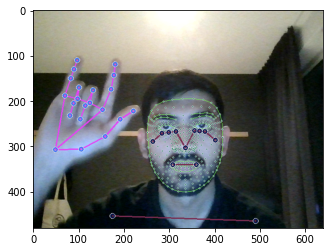

In [67]:
draw_styled_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [45]:
np.sum??

In [18]:
res

array([1.3740105e-03, 9.7520516e-04, 1.0282401e-03, ..., 5.0301710e-04,
       2.1678145e-04, 7.2393590e-08], dtype=float32)

In [19]:
res[np.argmax(res)]

0.0013740105

In [20]:
np.sum(res)

1.0